In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv 
# Loading Data
labels_names =['Stadium','Building','Traffic Sign','Forest','Flowers',
              'Street','Classroom','Bridge','Statue','Lake']
data_train = np.load('data_train.npy')
labels_train = np.load('labels_train.npy')
labels_train = labels_train.astype(int)

#train_dataset = tf.data.Dataset.from_tensor_slices((data_train, labels_train))

In [2]:
from PIL import Image
import os
import errno
#Converting data to directory
transposed_data = data_train.T

for idx, l in np.ndenumerate(labels_train):
   # data = data_train[:,idx]
    data = transposed_data[idx]
    img = Image.fromarray( data.reshape((300,300,3)), 'RGB')
    labelNr = l - 1
    filename = f'KerasPrep/{labels_names[labelNr]}/{idx[0]}.jpg'
    if not os.path.exists(os.path.dirname(filename)):
        try:
            os.makedirs(os.path.dirname(filename))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
    img.save(filename)

batch size 32
layers.RandomRotation(0.1),
layers.RandomZoom(0.1),
layers.Dropout(0.1),
randomflip: horizontal

-> Generalization 0.65


increased dropout to 0.2, added layer 128

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


def build_custom_model(batch_size, img_height, img_width, data_dir, validation_split,random_rotation,random_zoom,dropout):
    # dividing in classes train and validation 0.8 / 0.2
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=validation_split,
      subset="training",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

    num_classes = len(train_ds.class_names)
    print(num_classes)

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=validation_split,
      subset="validation",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    #flip the images and rotate and zoom to increase generalization.
    data_augmentation = keras.Sequential(
      [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                      img_width,
                                      3)),
        layers.RandomRotation(random_rotation),
        layers.RandomZoom(random_zoom),
        layers.Rescaling(1./255),
      ]
    )
    # Building the sequential model with relu acitivation function
    
    model = Sequential([
      data_augmentation,
        
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(dropout),
      layers.BatchNormalization(),
        
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(2),
      layers.Dropout(dropout),
        layers.BatchNormalization(),
        
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(2),
      layers.Dropout(dropout),
      layers.BatchNormalization(),
        
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(2),
      layers.Dropout(dropout),
        layers.BatchNormalization(),
        
      layers.Conv2D(128, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(dropout),
        layers.BatchNormalization(),
        
      layers.Conv2D(256, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(dropout),
        layers.BatchNormalization(),
        
      layers.Flatten(),
      layers.Dense(256, activation='relu'),
      layers.Dropout(dropout),
        layers.BatchNormalization(),
      layers.Dense(num_classes, activation = 'softmax')
    ])
    
    # use adam model optimizer.
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    model.summary()
    return model, train_ds, val_ds

Found 3124 files belonging to 10 classes.
Using 2500 files for training.


2021-11-28 23:38:34.647461: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-28 23:38:35.729275: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79124 MB memory:  -> device: 0, name: A100-SXM-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2021-11-28 23:38:35.732845: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79124 MB memory:  -> device: 1, name: A100-SXM-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0


10
Found 3124 files belonging to 10 classes.
Using 624 files for validation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 300, 300, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      4640      
___________________________________________

/apps/tensorflow/2.6.0/lib/python3.9/site-packages/keras/backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(
2021-11-28 23:38:37.479245: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-28 23:38:44.462243: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2021-11-28 23:38:46.610901: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


74/74 [==============================] - 14s 42ms/step - loss: 2.1490 - accuracy: 0.3356 - val_loss: 4.4916 - val_accuracy: 0.1090
Epoch 2/170
74/74 [==============================] - 2s 21ms/step - loss: 1.5227 - accuracy: 0.4904 - val_loss: 6.2950 - val_accuracy: 0.1090
Epoch 3/170
74/74 [==============================] - 2s 21ms/step - loss: 1.4350 - accuracy: 0.5308 - val_loss: 7.3026 - val_accuracy: 0.1090
Epoch 4/170
74/74 [==============================] - 1s 20ms/step - loss: 1.2979 - accuracy: 0.5692 - val_loss: 7.6264 - val_accuracy: 0.1186
Epoch 5/170
74/74 [==============================] - 1s 20ms/step - loss: 1.2258 - accuracy: 0.5996 - val_loss: 8.0848 - val_accuracy: 0.1090
Epoch 6/170
74/74 [==============================] - 1s 20ms/step - loss: 1.1733 - accuracy: 0.6084 - val_loss: 5.7659 - val_accuracy: 0.1298
Epoch 7/170
74/74 [==============================] - 2s 21ms/step - loss: 1.0890 - accuracy: 0.6292 - val_loss: 5.0626 - val_accuracy: 0.1490
Epoch 8/170
74/74

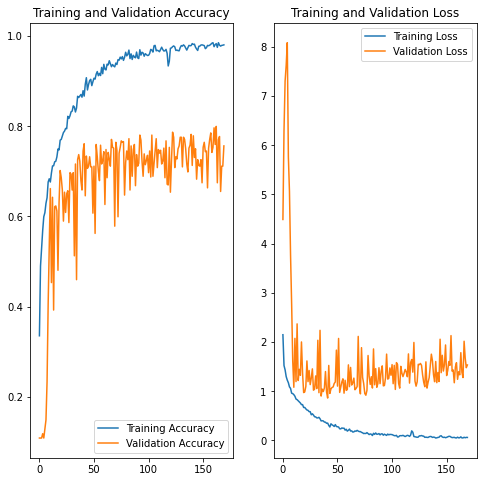

In [4]:
batch_size = 34
img_height = 300
img_width = 300
data_dir = 'KerasPrep'
validation_split = 0.2
random_rotation = 0.3
random_zoom = 0.3
dropout = 0.1

# build model
model, train_ds, val_ds = build_custom_model(batch_size, img_height, img_width, data_dir, validation_split,random_rotation,random_zoom,dropout)

#train model
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0.001, patience=6, verbose=0, mode='max',
    baseline=None, restore_best_weights=True
)

epochs=170
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  #callbacks = [callback]
)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

  
fields=[epochs,acc,img_height, img_width, data_dir, validation_split,random_rotation,random_zoom,dropout,val_acc,batch_size, model.get_config()]
with open(r'ML_results', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(fields)

In [8]:
# Load the TensorBoard notebook extension
%load_ext tensorboard


/bin/bash: conda: command not found

Note: you may need to restart the kernel to use updated packages.
